# Doing RAG in multiple modalities

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
"""
In data science a "modality" is essentially a type of data.
Text, images, audio, video, tables, these can all be considered different "modalities".
For a long time, these different types of data were seen as separated from one another, requiring data
scientists to create one model for doing stuff with text, another to do stuff with video, etc.
In recent years this conceptualization has dissolved, and models that can understand and work with multiple
modalities have become both more performant and more accessible. These models, which can understand multiple
types of data, are often referred to as "multimodal models"
"""

import google.generativeai as genai
from google.colab import userdata

os.environ["GOOGLE_API_KEY"]=userdata.get('818151282965')
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Load data

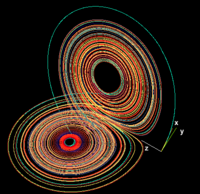

In [3]:
# First we can download the image from our dataset

import requests
from PIL import Image
from IPython.display import display

# loading image
url= 'https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Multimodal/MMRAG/Lorenz_Ro28-200px.png?raw=true'
response= requests.get(url, stream=True)
image= Image.open(response.raw).convert('RGB')

# save the image locally as jpg
save_path= 'image.jpg'
image.save(save_path, 'JPEG')
display(image)

In [4]:
#!{sys.executable} -m pip install pydub

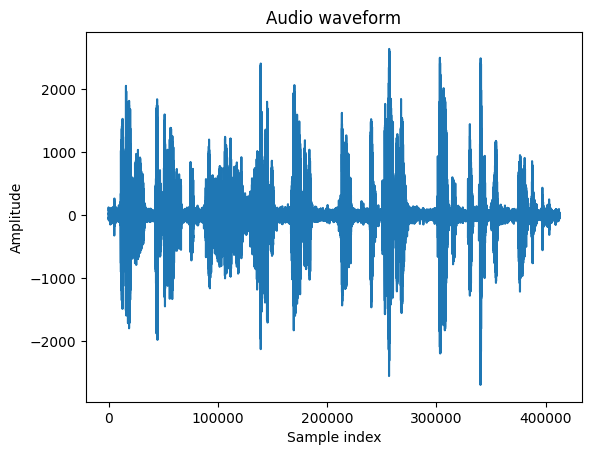

In [5]:
# Then, we can download our audio file

from pydub import AudioSegment
import io
import wave

# dowloading the audio file
url= "https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Multimodal/MMRAG/audio.mp3?raw=true"
response= requests.get(url)
audio_data= io.BytesIO(response.content)

# converting to wav and loading
audio_segment= AudioSegment.from_file(audio_data, format='mp3')

# downsampling to 16000 Hz - (this is necessary because a future model requires it to be at 16000Hz)
sampling_rate= 16000
audio_segment= audio_segment.set_frame_rate(sampling_rate)

# exporting the downsampled audio to a wav file in memory
wav_data= io.BytesIO()
audio_segment.export(wav_data, format='wav')
# back to beginning of IO for reading
wav_data.seek(0)
wav_file= wave.open(wav_data, 'rb')

# conveerting the audio data to a np array
frames= wav_file.readframes(-1)
audio_waveform= np.frombuffer(frames, dtype=np.int16).astype(np.float32)

# rendering audio waveform
plt.plot(audio_waveform)
plt.title('Audio waveform')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.show()

In [6]:
# And, finally, our Wikipedia transcript

# URL of the text file
url= "https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Multimodal/MMRAG/Wiki.txt?raw=true"
response= requests.get(url)
text_data= response.text

# truncating length for compatibility with an encoder that accepts all small context
# a different encoder could be used which allows for larger context lengths
text_data= text_data[:300]

print(text_data)

All Quiet on the Western Front (German: Im Westen nichts Neues, lit. 'In the West, nothing new') is a semi-autobiographical novel by Erich Maria Remarque, a German veteran of World War I. The book describes the German soldiers' extreme physical and mental trauma during the war as well as the detachm


In [8]:
# we have an audio file (which contains someone saying who is his/her favorite harpist) as well as an image and text file.

from transformers import (
    Speech2TextProcessor,
    Speech2TextForConditionalGeneration,
)

# the model that generates text based on speech audio
model= Speech2TextForConditionalGeneration.from_pretrained('facebook/s2t-medium-librispeech-asr')
# a processor that gets everything set up
processor= Speech2TextProcessor.from_pretrained('facebook/s2t-medium-librispeech-asr')

# passing through the model
inputs= processor(audio_waveform, sampling_rate=sampling_rate, return_tensors='pt')
generated_ids= model.generate(inputs['input_features'], attention_mask=inputs['attention_mask'])

# turning model output into text
audio_transcription= processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

audio_transcription

Some weights of Speech2TextForConditionalGeneration were not initialized from the model checkpoint at facebook/s2t-medium-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


"i recorded a more complex audiophile but i'm going to re record with a simpler one because it was surprisingly difficult my favorite harpist is trulo o'curlon toloh now torqualate iowa torqua"

# Embedding

In [10]:
# we use a CLIP style model to encode our images and text
query= 'who is my favorite harpist?'

from transformers import CLIPProcessor, CLIPModel

# load the model and processor
model= CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor= CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

# encode the image
inputs= processor(images=image, return_tensors='pt')
image_embeddings= model.get_image_features(**inputs)

# encode the text
inputs= processor(text=[query, audio_transcription, text_data], return_tensors='pt', padding=True)
text_embeddings= model.get_text_features(**inputs)

In [11]:
# unpack those results to get the encoding for the text, image, audio, and query,
# and calculate how different the data is to the query

from torch.nn.functional import cosine_similarity

# unpacking individual embeddings
image_embedding= image_embeddings[0]
query_embedding= text_embeddings[0]
audio_embedding= text_embeddings[1]
text__embedding= text_embeddings[2]

# calculate cosine similarity
cos_sim_query_image= cosine_similarity(query_embedding.unsqueeze(0), image_embedding.unsqueeze(0)).item()
cos_sim_query_audio= cosine_similarity(query_embedding.unsqueeze(0), audio_embedding.unsqueeze(0)).item()
cos_sim_query_text = cosine_similarity(query_embedding.unsqueeze(0), text__embedding.unsqueeze(0)).item()

# print the results
print(f"Cosine Similarity between query and image embedding: {cos_sim_query_image:.4f}")
print(f"Cosine Similarity between query and audio embedding: {cos_sim_query_audio:.4f}")
print(f"Cosine Similarity between query and text embedding: {cos_sim_query_text:.4f}")

Cosine Similarity between query and image embedding: 0.1996
Cosine Similarity between query and audio embedding: 0.7889
Cosine Similarity between query and text embedding: 0.4728


In [12]:
# The embedding derived from the audio transcript is deemed as the most relevant

# RAG - Retrieval Augmented Generation

In [14]:
"""
Retrieve: find the thing(s) that are the most relevant to the query
Augment: stick those things into a prompt for the language model, along with the query
Generate: Pass that to a language model to generate an answer
"""

# putting all the similarities in a list
similarities= [cos_sim_query_image, cos_sim_query_audio, cos_sim_query_text]

result= None

if (max(similarities)== cos_sim_query_image):
    # image most similar, augmenting with image
    model= genai.GenerativeModel('gemini-1.5-pro')
    result= model.generate_content([query, Image.open('image.jpeg')])

elif (max(similarities)== cos_sim_query_audio):
    # audio most similar, augmenting with the audio transcript
    model= genai.GenerativeModel('gemini-1.5-pro')
    result= model.generate_content([query, audio_transcription])

elif (max(similarities)== cos_sim_query_text):
    # text most similar, augmenting with text
    model= genai.GenerativeModel('gemini-1.5-pro')
    result= model.generate_content([query, text_data])

print(result.text)

It seems like you're having fun with words and names! There doesn't seem to be a harpist with the name you provided. It's likely you created a fictional one, which is very creative! 

If you're looking for real harpists to enjoy, there are many incredible ones out there. Do you have any preferences for the style of harp music you like? For example:

* **Classical:**  Look up artists like Xavier de Maistre, Catrin Finch, or Isabelle Perrin. 
* **Celtic:** Try Alan Stivell, Loreena McKennitt (she plays multiple instruments, including harp), or Cormac De Barra.
* **Modern/Experimental:**  Explore the work of Joanna Newsom, Zeena Parkins, or Mary Lattimore. 

Let me know what kind of harp music you enjoy, and I can give you more tailored recommendations! 



In [ ]:
# https://towardsdatascience.com/multimodal-rag-intuitively-and-exhaustively-explained-5713d8069eb0